In [29]:
!jupyter nbconvert --to script lstm.ipynb
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import random
import sys
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats
from datetime import datetime
#from geopy import distance

TEST_MODE = True
MODE = 'O3'

OUTPUT_DIR = 'plots/single2/'
OUTFILE = "training_single2_out.txt"

DATA_DIR = "/xace/d1/hamer"


[NbConvertApp] Converting notebook lstm.ipynb to script
[NbConvertApp] Writing 27610 bytes to lstm.py


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
if(not TEST_MODE):
    os.environ["CUDA_VISIBLE_DEVICES"]=str(sys.argv[1])

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:

CURRENT_CLUSTER = 0
if(not TEST_MODE):
    CURRENT_CLUSTER = sys.argv[2]

loclist = [[11030011], [40051008], [40070010], [40130019], [40131003], [40131030], [40132001], [40132005], [40133002], [40133003], [40134004], [40134005], [40134008], [40134010], [40134011], [40137020], [40137022], [40137024], [40139702], [40139704], [40170119], [40190021], [40191011], [40191018], [40191032], [40191034], [40258034], [40278011], [50350005], [51190007], [51430005], [60190007], [60192009], [60194001], [60195001], [60250005], [60290011], [60290232], [60292012], [60296001], [60370002], [60371103], [60371201], [60371302], [60371602], [60372005], [60375005], [60376012], [60379033], [60470003], [60590007], [60592022], [60610006], [60650012], [60656001], [60658001], [60658005], [60659001], [60670002], [60670006], [60670010], [60690003], [60710001], [60710005], [60710012], [60710306], [60711234], [60712002], [60714001], [60714003], [60730001], [60731006], [60731008], [60731016], [60731022], [60773005], [60793001], [60794002], [60831008], [60831021], [60832004], [60833001], [60890004], [60890007], [60990005], [61072002], [61110007], [61111004], [80050002], [80130014], [80310002], [80410013], [80450012], [80677001], [80690011], [90031003], [110010041], [120050006], [120230002], [120330004], [120330018], [120571035], [120573002], [120712002], [120713002], [120730012], [120814012], [120814013], [120830003], [120910002], [121010005], [121030004], [121030018], [121056005], [121130015], [121151005], [121151006], [121152002], [121171002], [130890002], [160010010], [191530030], [191531579], [200910010], [201030003], [201330003], [201730010], [250010002], [250051006], [250070001], [250092006], [250095005], [250130008], [250170009], [250213003], [250230005], [250250042], [250270024], [271390505], [291370001], [295100085], [300298001], [300630024], [300870001], [310550019], [320310016], [320310020], [320310025], [320311007], [320312002], [325100020], [330050007], [330090010], [330115001], [330150014], [340070002], [340170006], [340190001], [340210005], [340273001], [350130022], [350130023], [350250008], [350431001], [350490021], [360010012], [360050110], [360270007], [360290002], [360450002], [360610135], [360671015], [360715001], [360790005], [360810124], [361030009], [361173001], [361192004], [371190041], [380070002], [380150003], [380570004], [381050003], [390350060], [390610040], [400270049], [400370144], [401091037], [401431127], [410510080], [410670005], [420030008], [420030067], [420031008], [420050001], [420070005], [420070014], [420150011], [420170012], [420210011], [420290100], [420431100], [420450002], [420630004], [420690101], [420692006], [420710012], [420750100], [420850100], [421010048], [421255001], [421330011], [460990008], [470090101], [471570075], [471571004], [480271045], [480271047], [480290032], [480611023], [480850005], [481130075], [481210034], [481390016], [481391044], [481410029], [481410037], [481410057], [481410058], [481671034], [481830001], [482010024], [482010029], [482010066], [482011017], [482011034], [482011035], [482011039], [482011050], [482030002], [482150043], [482311006], [482450009], [482450011], [482450101], [482510003], [482570005], [483091037], [483390078], [483550026], [483611001], [483670081], [483970001], [484230007], [484393009], [484690003], [490050007], [490110004], [490353006], [490471004], [490495010], [490530007], [500210002], [510870014], [530330080], [530570011], [530730005], [540390020], [550270001], [550790026], [560450003]]
LOCATIONS = loclist[int(CURRENT_CLUSTER)]

#if(MODE == 'pm25'):
#    LOCATIONS = [61104]
#    LOCATIONS = [40134005]#, 10735003, 11011002, 11030011]

ERRVAL = -999000.0
if(MODE == 'pm25'):
    ERRVAL = -999.0

STOP_DATE = '2019-12-29'
#STOP_DATE = '2019-08-29'

PHYSICAL_VARIABLES = ['O3', 'TEMP2', 'RGRND', 'PBL2', 'WDIR10', 'WSPD10', 'NOX', 'NOY', 'TIMEOFDAY']
if(MODE == 'pm25'):
    PHYSICAL_VARIABLES = ['pm25', 'RC', 'RGRND', 'RN', 'TEMP2', 'WDIR10', 'WSPD10', 'TIMEOFDAY']
#    PHYSICAL_VARIABLES = ['pm25']
    
LAYERS = 5
EPOCHS = 1#100
UNITS = 1#200
if(not TEST_MODE):
    EPOCHS = 100#100
    UNITS = 200#200
DROPOUT = 0.25
PATIENCE = 5.0
LSTM_TYPES = ['pre', 'mid', 'end']
TYPE_OFFSETS = {'pre': 0, 'mid': int(24/2), 'end': 23}

TEST_DAYS = ['2019-07-13', '2019-07-23', '2019-08-04', '2019-08-14', '2019-09-08', '2019-09-20', '2019-10-01', '2019-10-30', '2019-11-09', '2019-11-22']#, '2019-12-05', '2019-12-29']
TEST_LOCATIONS = LOCATIONS

In [4]:
f = open(OUTFILE, "w")
f.write("Beginning cluster "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.close()
f = open(OUTFILE, "a")
f.write("Starting data for "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.close()

In [5]:
airnow_data, forecast_data = pickle.load(open(DATA_DIR+"/pickle_files/data_"+MODE+".p", "rb"))

airnow_data = airnow_data[LOCATIONS]
forecast_data = forecast_data[np.in1d(forecast_data.index.get_level_values(1), LOCATIONS)].loc[:STOP_DATE]

# We need one scaler for each variable, so we use a dictionary to store them all
scaler = {}

# We make a copy of the forecast data so we do not accidentally modify the original
forecast_data_scaled = copy.copy(forecast_data)

for variable in tqdm(PHYSICAL_VARIABLES, desc='Normalizing Data'):
    
    # The forecast data is sliced to get all values of a specific physical variable for the locations
    # currently being used.

    #current_forecast = forecast_data.loc[(slice(None), slice(*LOCATIONS)),variable]
    current_forecast = forecast_data.loc[(slice(None), slice(None)),variable]
    
    current_variable_data = np.array(current_forecast)

    # Ozone/pm25 needs to be handled differently, since we need to include the AirNow observations
    # when generating the scaler (because AirNow observations are of ozone/pm25 concentration)
    if(variable==MODE):
        
        # The AirNow data contains some invalid values which need to not be considered
        # when generating the scaler, so we ensure those values do not get included along
        # with the rest of the data
        current_airnow =  np.array(airnow_data[LOCATIONS])
        current_airnow = current_airnow[current_airnow != ERRVAL]
        current_variable_data = np.concatenate([current_variable_data,current_airnow.flatten()])
        
    # The scaler is then generated using all values of the physical variable
    scaler[variable] = StandardScaler().fit(np.array(current_variable_data).reshape(-1,1))
    print(scaler[variable].mean_)
    # The scaled data is inserted into the scaled forecast dataframe.
    scaled_data = scaler[variable].transform(np.array(current_forecast).reshape(-1,1))
    #forecast_data_scaled.loc[(slice(None), slice(*LOCATIONS)),variable] = scaled_data
    forecast_data_scaled.loc[(slice(None), slice(None)),variable] = scaled_data

Normalizing Data:   0%|          | 0/9 [00:00<?, ?it/s]

[26.62589872]
[292.11716333]
[183.98813811]
[469.38528968]
[176.59454137]
[2.60316104]
[0.00559548]
[0.00806709]
[11.5]


In [6]:
airnow_data

stationid,11030011
2019-07-01 13:00:00,18.0
2019-07-01 14:00:00,34.0
2019-07-01 15:00:00,41.0
2019-07-01 16:00:00,46.0
2019-07-01 17:00:00,47.0
...,...
2019-12-31 19:00:00,1.0
2019-12-31 20:00:00,1.0
2019-12-31 21:00:00,1.0
2019-12-31 22:00:00,1.0


In [7]:
forecast_data_scaled

var                                              NOX       NOY        O3  \
forecast_day stationid date_time                                           
2019-07-01   11030011  2019-07-01 13:00:00  0.216688  0.106301 -0.399857   
                       2019-07-01 14:00:00  0.123335  0.126839  0.187785   
                       2019-07-01 15:00:00 -0.368046 -0.203720  0.931567   
                       2019-07-01 16:00:00 -0.878080 -0.626936  1.412606   
                       2019-07-01 17:00:00 -0.989878 -0.719213  1.559622   
...                                              ...       ...       ...   
2019-12-29   11030011  2019-12-31 08:00:00 -0.910610 -1.157321  0.045970   
                       2019-12-31 09:00:00 -0.907442 -1.154005  0.007242   
                       2019-12-31 10:00:00 -0.901548 -1.149482 -0.025542   
                       2019-12-31 11:00:00 -0.887712 -1.137193 -0.050978   
                       2019-12-31 12:00:00 -0.846117 -1.097228 -0.081041   

var                                             PBL2     RGRND     TEMP2  \
forecast_day stationid date_time                                           
2019-07-01   11030011  2019-07-01 13:00:00 -0.678662  0.197295  0.426346   
                       2019-07-01 14:00:00 -0.422485  0.739959  0.701196   
                       2019-07-01 15:00:00 -0.086148  1.434624  0.898980   
                       2019-07-01 16:00:00  1.338154  2.042121  1.077126   
                       2019-07-01 17:00:00  2.088448  2.496076  1.224067   
...                                              ...       ...       ...   
2019-12-29   11030011  2019-12-31 08:00:00 -0.068745 -0.656237 -1.540390   
                       2019-12-31 09:00:00 -0.071919 -0.656237 -1.583398   
                       2019-12-31 10:00:00 -0.173663 -0.656237 -1.622557   
                       2019-12-31 11:00:00 -0.281175 -0.656237 -1.651895   
                       2019-12-31 12:00:00 -0.346460 -0.656237 -1.669557   

var                                         TIMEOFDAY    WDIR10    WSPD10  
forecast_day stationid date_time                                           
2019-07-01   11030011  2019-07-01 13:00:00   0.216695  0.400788 -1.386486  
                       2019-07-01 14:00:00   0.361158  1.324218 -0.545097  
                       2019-07-01 15:00:00   0.505621  1.494781 -0.229457  
                       2019-07-01 16:00:00   0.650084  1.506061  0.059317  
                       2019-07-01 17:00:00   0.794547  1.450551  0.516939  
...                                               ...       ...       ...  
2019-12-29   11030011  2019-12-31 08:00:00  -0.505621  0.764297  0.281594  
                       2019-12-31 09:00:00  -0.361158  0.809094  0.231856  
                       2019-12-31 10:00:00  -0.216695  0.764951  0.169815  
                       2019-12-31 11:00:00  -0.072232  0.696075  0.120948  
                       2019-12-31 12:00:00   0.072232  0.620676  0.090182  

[8736 rows x 9 columns]

In [8]:
ALL_FORECAST_DAYS = np.unique(forecast_data_scaled.index.get_level_values('forecast_day'))

print("Generating Timesteps")

# Create a list to hold each location's forecast days as dataframes
locations = []

for forecast_location in tqdm(LOCATIONS, desc="Locations"): #[:limiter]
    
    # Create a list to hold each forecast day's timesteps
    days = []
    
    for forecast_day in ALL_FORECAST_DAYS: # [:limiter]
        
        # Given a particular forecast day and a partiular location, we generate all 24 hour timesteps for that day
        # as invidivual dataframes and put them together into a list.
        #timesteps = [forecast_data_scaled.loc[forecast_day].loc[forecast_location].iloc[i:i+24] for i in range(25-1)]
        data = forecast_data_scaled.loc[forecast_day].loc[forecast_location]
        timesteps = [data.iloc[i:i+24] for i in range(25-1)]

        # We combine these dataframes together into a single large dataframe using a new index (timestep) to reference each one
        current_day = pd.concat(timesteps, keys=range(25-1), axis=0, names=['timestep', *timesteps[0].index.names])
        
        # This large dataframe is in turn added to the list of combined timestep dataframes for each forecast day for the current location
        days.append(current_day)
    
    # The dataframes for each forecast day are themselves combined together to create a single very large dataframe for the current location
    current_location = pd.concat(days, keys=ALL_FORECAST_DAYS, axis=0, names=['forecast_day', *days[0].index.names])
    locations.append(current_location)
    
# The same process as above is repeated to combine the very large dataframes from each location together
# into a single massive one for each lstm type
all_training_data = pd.concat(locations, keys=LOCATIONS, axis=0, names=['stationid', *locations[0].index.names])

Generating Timesteps


Locations:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
all_training_data

var                                                       NOX       NOY  \
stationid forecast_day timestep date_time                                 
11030011  2019-07-01   0        2019-07-01 13:00:00  0.216688  0.106301   
                                2019-07-01 14:00:00  0.123335  0.126839   
                                2019-07-01 15:00:00 -0.368046 -0.203720   
                                2019-07-01 16:00:00 -0.878080 -0.626936   
                                2019-07-01 17:00:00 -0.989878 -0.719213   
...                                                       ...       ...   
          2019-12-29   23       2019-12-31 07:00:00 -0.907141 -1.154125   
                                2019-12-31 08:00:00 -0.910610 -1.157321   
                                2019-12-31 09:00:00 -0.907442 -1.154005   
                                2019-12-31 10:00:00 -0.901548 -1.149482   
                                2019-12-31 11:00:00 -0.887712 -1.137193   

var                                                        O3      PBL2  \
stationid forecast_day timestep date_time                                 
11030011  2019-07-01   0        2019-07-01 13:00:00 -0.399857 -0.678662   
                                2019-07-01 14:00:00  0.187785 -0.422485   
                                2019-07-01 15:00:00  0.931567 -0.086148   
                                2019-07-01 16:00:00  1.412606  1.338154   
                                2019-07-01 17:00:00  1.559622  2.088448   
...                                                       ...       ...   
          2019-12-29   23       2019-12-31 07:00:00  0.088469  0.081330   
                                2019-12-31 08:00:00  0.045970 -0.068745   
                                2019-12-31 09:00:00  0.007242 -0.071919   
                                2019-12-31 10:00:00 -0.025542 -0.173663   
                                2019-12-31 11:00:00 -0.050978 -0.281175   

var                                                     RGRND     TEMP2  \
stationid forecast_day timestep date_time                                 
11030011  2019-07-01   0        2019-07-01 13:00:00  0.197295  0.426346   
                                2019-07-01 14:00:00  0.739959  0.701196   
                                2019-07-01 15:00:00  1.434624  0.898980   
                                2019-07-01 16:00:00  2.042121  1.077126   
                                2019-07-01 17:00:00  2.496076  1.224067   
...                                                       ...       ...   
          2019-12-29   23       2019-12-31 07:00:00 -0.656237 -1.499015   
                                2019-12-31 08:00:00 -0.656237 -1.540390   
                                2019-12-31 09:00:00 -0.656237 -1.583398   
                                2019-12-31 10:00:00 -0.656237 -1.622557   
                                2019-12-31 11:00:00 -0.656237 -1.651895   

var                                                  TIMEOFDAY    WDIR10  \
stationid forecast_day timestep date_time                                  
11030011  2019-07-01   0        2019-07-01 13:00:00   0.216695  0.400788   
                                2019-07-01 14:00:00   0.361158  1.324218   
                                2019-07-01 15:00:00   0.505621  1.494781   
                                2019-07-01 16:00:00   0.650084  1.506061   
                                2019-07-01 17:00:00   0.794547  1.450551   
...                                                        ...       ...   
          2019-12-29   23       2019-12-31 07:00:00  -0.650084  0.748020   
                                2019-12-31 08:00:00  -0.505621  0.764297   
                                2019-12-31 09:00:00  -0.361158  0.809094   
                                2019-12-31 10:00:00  -0.216695  0.764951   
                                2019-12-31 11:00:00  -0.072232  0.696075   

var                                                    WSPD10  
stationid forecast_

Extract the testing data from the forecast data

In [11]:
test_data = {}
for day in TEST_DAYS:
    test_data[day] = {}
    for loc in TEST_LOCATIONS:
        test_data[day][loc] = copy.copy(all_training_data.xs(loc, level="stationid", axis=0).loc[day])

Mark the forecast day we extracted as invalid so it will be removed later. We also remove the previous day since its forecast data extends into the testing day.

In [12]:
for loc in TEST_LOCATIONS:
    for day in TEST_DAYS:
        all_training_data.loc[loc,day] = ERRVAL
        prev_day = str(pd.to_datetime(day)-pd.Timedelta(1, 'd'))[:10]
        all_training_data.loc[loc,prev_day] = ERRVAL

Test data is generated by matching up each timestep in the testing set's forecast data to the corresponding airnow observation

In [13]:
# lstm_type, location, forecast_day, timestep_number, time
X_test = {}
Y_test = {}
# lstm_type, location, forecast_day, timestep_number


# We create a dictionary entry for each LSTM type
for lstm_type in LSTM_TYPES:

    X_test[lstm_type] = {}
    Y_test[lstm_type] = {}
    
    # and for each test day
    for day in TEST_DAYS:
        
        X_test[lstm_type][day] = {}
        Y_test[lstm_type][day] = {}

        for loc in TEST_LOCATIONS:

            # The test data set is reshaped into an array where each entry is a 24 hour timestep
            X_test[lstm_type][day][loc] = np.array(test_data[day][loc]).reshape((-1,24,len(PHYSICAL_VARIABLES)))
            #if(lstm_type=='pre' and loc == TEST_LOCATIONS[1]):
            #    print(X_test[lstm_type][day][loc])
            #    print('-----------------------------------------')

            # In order to create the ground truth for the testing set, we need to know what time span we need to pull from.
            # Each 24 hour timestep has a ground truth airnow observation value associated with it (which is what the LSTM 
            # is trying to use that timestep to predict). This time of this airnow observation is either at the beginning
            # of the 24 hour block (for the "pre" LSTM), in the middle of the block (for the "mid" LSTM), or at the end
            # (for the "end" LSTM). For an entire 48 hour forecast day (which has 24 timesteps in it), this means that we
            # are interested in the observations of the first 24 hours of the day (for 'pre'), the middle 24 (for 'mid'),
            # and the final 24 (for 'end'). We can easily generate the specific list of times we are interested by staring
            # at 13:00 GMT of the forecast day, adding an offset to it depending on the lstm type, then getting all observations
            # for the next 24 hours onwards.
            start_time = pd.to_datetime(day+' 13:00:00')+pd.Timedelta(TYPE_OFFSETS[lstm_type], 'h')
            times = pd.date_range(start_time, periods=24, freq="H")
    
            Y_test[lstm_type][day][loc] = np.array(airnow_data.loc[times][loc])

Training and validation data is generated by matching up each timestep in the main data set's forecast data to the corresponding airnow observation

In [14]:

X = {}
Y = {}

# We create a dictionary entry for each LSTM type
for lstm_type in LSTM_TYPES:
    
    print("Generating training data for '"+lstm_type+"' LSTM")
    
    X[lstm_type] = np.array(all_training_data).reshape((-1,24,len(PHYSICAL_VARIABLES)))

    current_data_X = []
    current_data_Y = []
    
    for current_ids in tqdm(np.unique(all_training_data.index.get_level_values('stationid'))):
        for current_day in np.unique(all_training_data.index.get_level_values('forecast_day')):
    
            # The test data set is reshaped into an array where ecah entry is a 24 hour timestep

            # In order to create the ground truth for the testing set, we need to know what time span we need to pull from.
            # Each 24 hour timestep has a ground truth airnow observation value associated with it (which is what the LSTM 
            # is trying to use that timestep to predict). This time of this airnow observation is either at the beginning
            # of the 24 hour block (for the "pre" LSTM), in the middle of the block (for the "mid" LSTM), or at the end
            # (for the "end" LSTM). For an entire 48 hour forecast day (which has 24 timesteps in it), this means that we
            # are interested in the observations of the first 24 hours of the day (for 'pre'), the middle 24 (for 'mid'),
            # and the final 24 (for 'end'). We can easily generate the specific list of times we are interested by staring
            # at 13:00 GMT of the forecast day, adding an offset to it depending on the lstm type, then getting all observations
            # for the next 24 hours onwards.
            start_time = pd.to_datetime(current_day+' 13:00:00')+pd.Timedelta(TYPE_OFFSETS[lstm_type], 'h')
            times = pd.date_range(start_time, periods=24, freq="H")

            current_data_Y.append(np.array(airnow_data.loc[times][current_ids]))
            
    Y[lstm_type] = np.concatenate(current_data_Y)

Generating training data for 'pre' LSTM


  0%|          | 0/1 [00:00<?, ?it/s]

Generating training data for 'mid' LSTM


  0%|          | 0/1 [00:00<?, ?it/s]

Generating training data for 'end' LSTM


  0%|          | 0/1 [00:00<?, ?it/s]

Invalid values are removed from the training data

In [15]:
X_cleaned = {}
Y_cleaned = {}

for lstm_type in LSTM_TYPES:
    invalid_X = np.unique(np.where(X[lstm_type] <= ERRVAL)[0])
    invalid_Y = np.where(Y[lstm_type] <= ERRVAL)[0]

    invalid_data = np.concatenate([invalid_X, invalid_Y])
    #print(invalid_data)

    X_cleaned[lstm_type] = np.delete(X[lstm_type], invalid_data, axis=0)
    Y_cleaned[lstm_type] = np.delete(Y[lstm_type], invalid_data)
    
    # Here we finally normalize the ground truth observations (we held off on this since we did not want to
    # modify the special -999000/-999 value that indicated invalid data, since we were using that in order to clean
    # the training and validation sets)
    Y_cleaned[lstm_type] = scaler[MODE].transform(Y_cleaned[lstm_type].reshape(-1,1)).reshape((-1,))

Non-testing data is shuffled

In [16]:
X_final = {}
Y_final = {}

for lstm_type in LSTM_TYPES:
    perm = np.random.default_rng().permutation(Y_cleaned[lstm_type].shape[0])
    X_final[lstm_type] = X_cleaned[lstm_type][perm]
    Y_final[lstm_type] = Y_cleaned[lstm_type][perm]

Data is separated into training and validation sets

In [17]:
X_train = {}
Y_train = {}

X_val = {}
Y_val = {}

for lstm_type in LSTM_TYPES:
    
    index = int(X_final[lstm_type].shape[0]*0.95)
    
    X_train[lstm_type] = X_final[lstm_type][:index]
    Y_train[lstm_type] = Y_final[lstm_type][:index]
    
    X_val[lstm_type] = X_final[lstm_type][index:]
    Y_val[lstm_type] = Y_final[lstm_type][index:]

In [18]:
plt.plot([0,1,2,3,4], label='LSTM', color="red", linewidth=0.75)

if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
plt.savefig(OUTPUT_DIR+"/proof.png", dpi=100)

In [19]:
f = open(OUTFILE, "a")
f.write("Finished data for "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.write("Starting training for "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.close()

In [20]:
# [samples, timesteps, features]
model = {}
history = {}
for lstm_type in LSTM_TYPES:
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=PATIENCE)
    model[lstm_type] = tf.keras.Sequential()
    
    if(LAYERS <= 1):
        model[lstm_type].add(
            tf.keras.layers.Bidirectional(
                tf.keras.layers.GRU(UNITS, input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2]),
                                     dropout=DROPOUT, stateful=False, return_sequences=False),
                input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
    else:
        model[lstm_type].add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(UNITS, input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2]), dropout=DROPOUT, stateful=False, return_sequences=True), input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
        for i in range(LAYERS-2):
            model[lstm_type].add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(UNITS, dropout=DROPOUT, stateful=False, return_sequences=True), input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
        model[lstm_type].add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(UNITS, dropout=DROPOUT, stateful=False, return_sequences=False), input_shape=(X_train[lstm_type].shape[1], X_train[lstm_type].shape[2])))
    
    model[lstm_type].add(tf.keras.layers.Dense(1))
    model[lstm_type].compile(loss='mae', optimizer='adam')
    model[lstm_type].summary()
    #history[lstm_type] = model[lstm_type].fit(X_train[lstm_type], Y_train[lstm_type], epochs=EPOCHS, batch_size=32, validation_data=(X_val[lstm_type], Y_val[lstm_type]), verbose=1, shuffle=False, callbacks=[early_stopping, reduce_lr])
    #history[lstm_type] = model[lstm_type].fit(X_train[lstm_type], Y_train[lstm_type], epochs=EPOCHS, batch_size=32, validation_data=(X_val[lstm_type], Y_val[lstm_type]), verbose=1, shuffle=False, callbacks=[reduce_lr])
    history[lstm_type] = model[lstm_type].fit(X_train[lstm_type], Y_train[lstm_type], epochs=EPOCHS, batch_size=32, validation_data=(X_val[lstm_type], Y_val[lstm_type]), verbose=1, shuffle=False)
    #model[lstm_type].save(os.path.join(HP["model_dir"],lstm_type))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 24, 2)             72        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 2)             30        
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 2)             30        
_________________________________________________________________
bidirectional_3 (Bidirection (None, 24, 2)             30        
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2)                 30        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 195
Trainable params: 195
Non-trainable params: 0
__________________________________________________________

In [21]:
f = open(OUTFILE, "a")
f.write("Finished training for "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.write("Starting correction for "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.close()

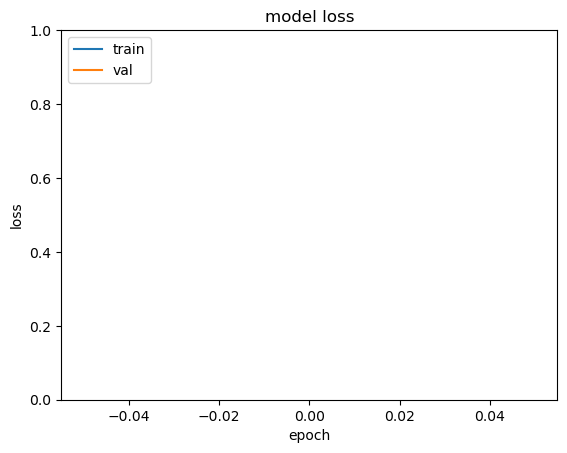

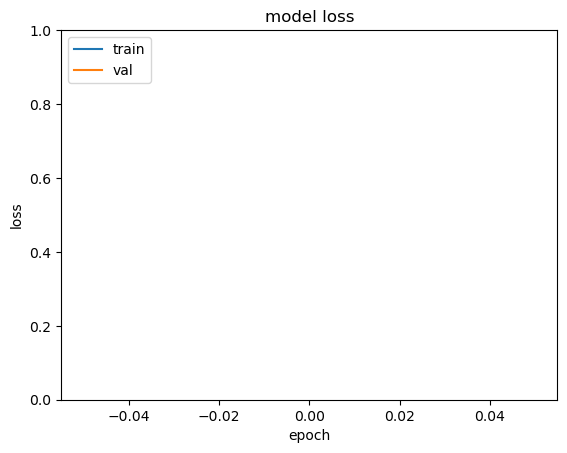

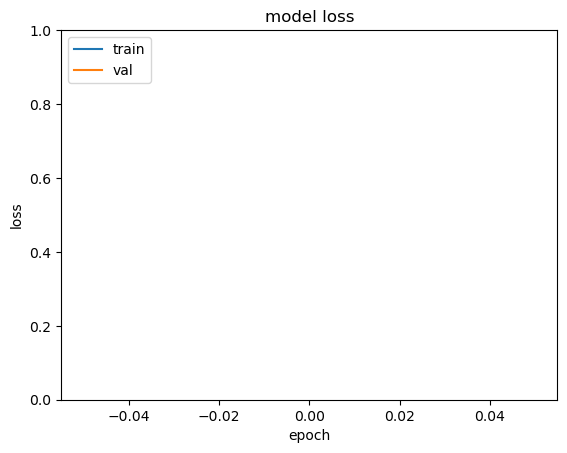

In [22]:
for lstm_type in LSTM_TYPES:
    plt.clf()
    plt.plot(history[lstm_type].history['loss'])
    plt.plot(history[lstm_type].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim([0,1])
    plt.legend(['train', 'val'], loc='upper left')
    if(not(os.path.exists(OUTPUT_DIR))):
        os.makedirs(OUTPUT_DIR)
    plt.savefig(OUTPUT_DIR+"/training.png", dpi=100)  
    plt.show()

In [24]:
model_output = {}

for lstm_type in LSTM_TYPES:
    model_output[lstm_type] = {}
    for day in TEST_DAYS:
        model_output[lstm_type][day] = {}
        for loc in TEST_LOCATIONS:
            predict = model[lstm_type].predict(X_test[lstm_type][day][loc])
            model_output[lstm_type][day][loc] = scaler[MODE].inverse_transform([predict.flatten()]).reshape(predict.shape)
            #if(lstm_type=='pre' and loc == TEST_LOCATIONS[1]):
            #    print(X_test[lstm_type][day][loc])
            #    print('-----------------------------------------')
                #print(str(day),str(loc),str(model_output[lstm_type][day][loc]))

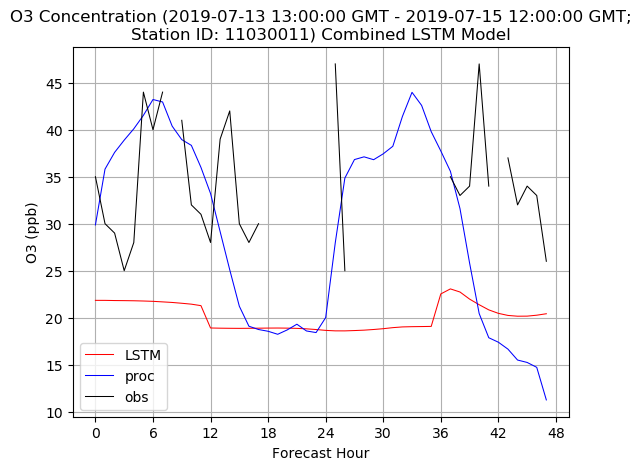

Forecast RMSE: 12.111420175332727
LSTM RMSE: 14.530152401216492
Forecast RMSE (first 24 hours): 6.994489812162406
LSTM RMSE (first 24 hours): 13.943044038220172
Forecast Pearson Correlation: 0.11577882314701633
LSTM Pearson Correlation: 0.18626543944948046

Maximum for first 15 hours:
Forecast Max: 43.2130241394043
LSTM Max: 21.843670089365112
AirNow Max: 44.0

Maximum for next 24 hours:
Forecast Max: 39.796234130859375
LSTM Max: 23.062708437807036
AirNow Max: 47.0


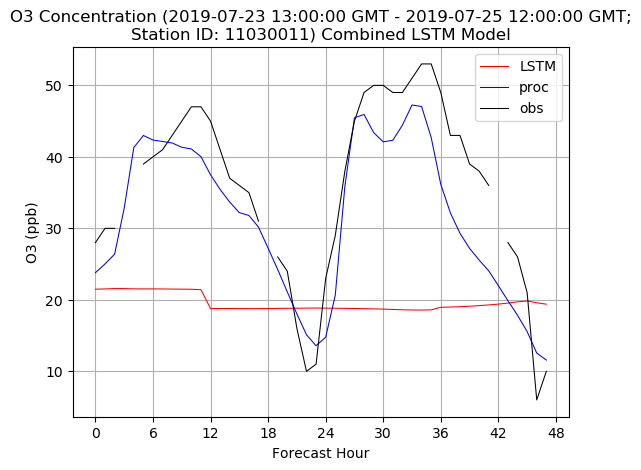

Forecast RMSE: 6.643488493120908
LSTM RMSE: 20.64783380047627
Forecast RMSE (first 24 hours): 4.68474351994647
LSTM RMSE (first 24 hours): 19.81621440427521
Forecast Pearson Correlation: 0.920341567549979
LSTM Pearson Correlation: -0.0040031791203050116

Maximum for first 15 hours:
Forecast Max: 42.993324279785156
LSTM Max: 21.572906918583033
AirNow Max: 47.0

Maximum for next 24 hours:
Forecast Max: 47.254051208496094
LSTM Max: 19.54554931783476
AirNow Max: 53.0


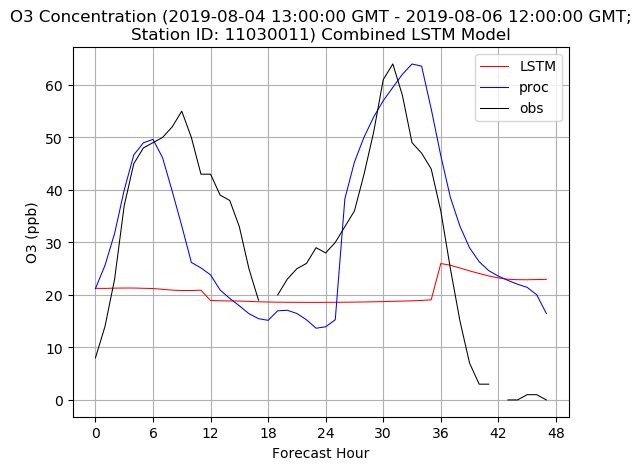

Forecast RMSE: 14.13471604134837
LSTM RMSE: 22.174043635609127
Forecast RMSE (first 24 hours): 12.669473702575878
LSTM RMSE (first 24 hours): 23.864727229804544
Forecast Pearson Correlation: 0.669631533790161
LSTM Pearson Correlation: -0.5032070845994727

Maximum for first 15 hours:
Forecast Max: 49.634796142578125
LSTM Max: 21.31126572297319
AirNow Max: 55.0

Maximum for next 24 hours:
Forecast Max: 63.985103607177734
LSTM Max: 25.982507218600475
AirNow Max: 64.0


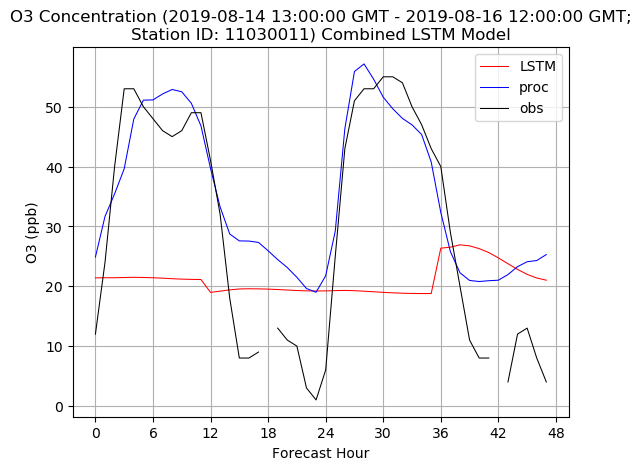

Forecast RMSE: 10.475925159730563
LSTM RMSE: 21.653645204291777
Forecast RMSE (first 24 hours): 7.129815488885144
LSTM RMSE (first 24 hours): 24.64648479558669
Forecast Pearson Correlation: 0.9365462973282992
LSTM Pearson Correlation: -0.2339726847818344

Maximum for first 15 hours:
Forecast Max: 52.8826789855957
LSTM Max: 21.490701862595476
AirNow Max: 53.0

Maximum for next 24 hours:
Forecast Max: 57.15366744995117
LSTM Max: 26.92014400552026
AirNow Max: 55.0


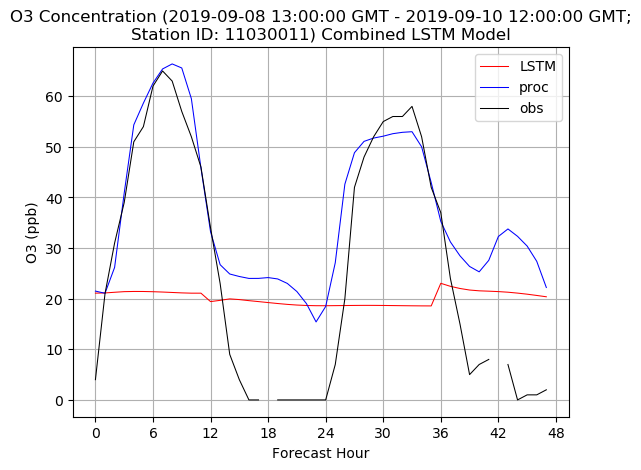

Forecast RMSE: 15.4772798092149
LSTM RMSE: 24.198065394707395
Forecast RMSE (first 24 hours): 6.507809623706256
LSTM RMSE (first 24 hours): 29.994776818616327
Forecast Pearson Correlation: 0.9295133041457396
LSTM Pearson Correlation: 0.0403522030585259

Maximum for first 15 hours:
Forecast Max: 66.3895034790039
LSTM Max: 21.430879072763407
AirNow Max: 65.0

Maximum for next 24 hours:
Forecast Max: 52.99576187133789
LSTM Max: 23.03997785879985
AirNow Max: 58.0


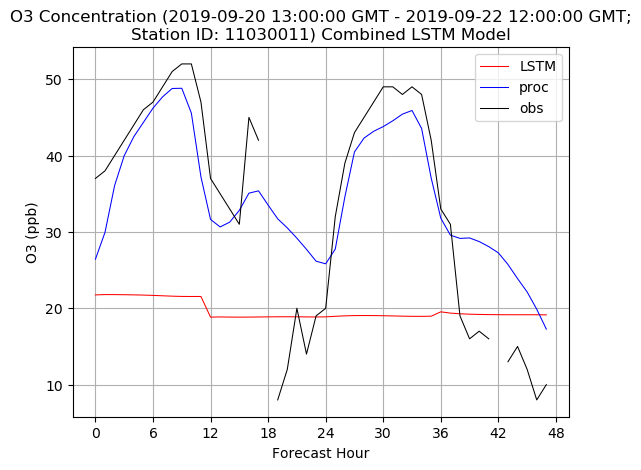

Forecast RMSE: 8.198721313240364
LSTM RMSE: 19.56069173948391
Forecast RMSE (first 24 hours): 5.447592814473708
LSTM RMSE (first 24 hours): 24.283594544961954
Forecast Pearson Correlation: 0.8777817533682768
LSTM Pearson Correlation: 0.4569282816359996

Maximum for first 15 hours:
Forecast Max: 48.8127555847168
LSTM Max: 21.79621528343555
AirNow Max: 52.0

Maximum for next 24 hours:
Forecast Max: 45.90175247192383
LSTM Max: 19.535655206968812
AirNow Max: 49.0


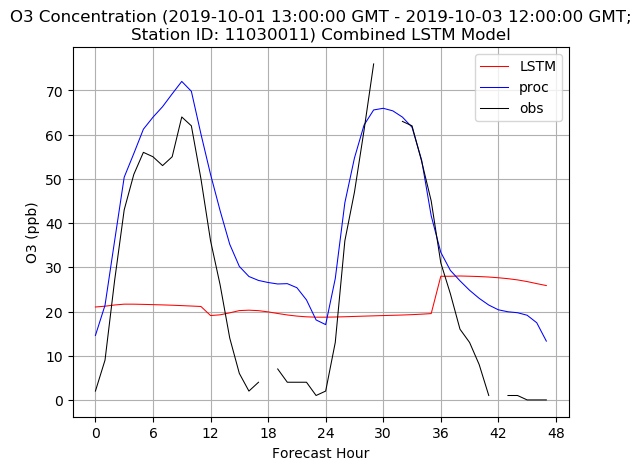

Forecast RMSE: 14.362604755379417
LSTM RMSE: 26.056331398882584
Forecast RMSE (first 24 hours): 9.940175118106195
LSTM RMSE (first 24 hours): 29.713034118654146
Forecast Pearson Correlation: 0.9656473119454082
LSTM Pearson Correlation: -0.33252295905665874

Maximum for first 15 hours:
Forecast Max: 72.04305267333984
LSTM Max: 21.661020631313235
AirNow Max: 64.0

Maximum for next 24 hours:
Forecast Max: 65.58944702148438
LSTM Max: 28.03242860875841
AirNow Max: 76.0


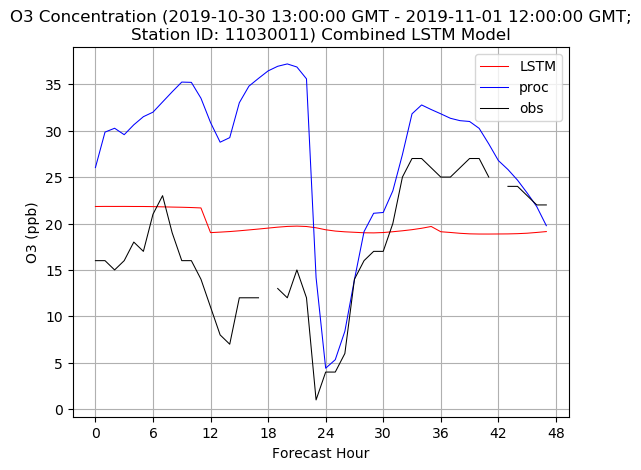

Forecast RMSE: 13.37689357048966
LSTM RMSE: 7.500693122268474
Forecast RMSE (first 24 hours): 14.862087488041775
LSTM RMSE (first 24 hours): 5.176534479081514
Forecast Pearson Correlation: 0.37649595110682416
LSTM Pearson Correlation: -0.06514065087176026

Maximum for first 15 hours:
Forecast Max: 35.231361389160156
LSTM Max: 21.841299351925084
AirNow Max: 23.0

Maximum for next 24 hours:
Forecast Max: 37.18701171875
LSTM Max: 19.717583636698475
AirNow Max: 27.0


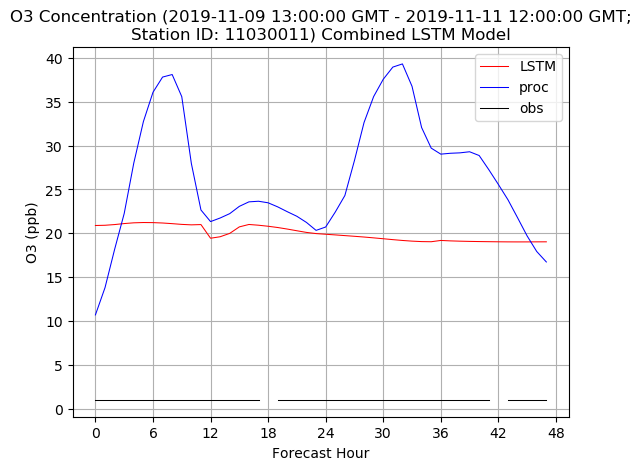

Forecast RMSE: 26.448291673089592
LSTM RMSE: 18.991178748262804
Forecast RMSE (first 24 hours): 27.526859046248912
LSTM RMSE (first 24 hours): 20.06363702350578
Forecast Pearson Correlation: nan
LSTM Pearson Correlation: nan

Maximum for first 15 hours:
Forecast Max: 38.09806823730469
LSTM Max: 21.224850985025217
AirNow Max: 1.0

Maximum for next 24 hours:
Forecast Max: 39.30707550048828
LSTM Max: 21.002794980987783
AirNow Max: 1.0


/home/chamer/miniconda3/envs/bias_correction/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


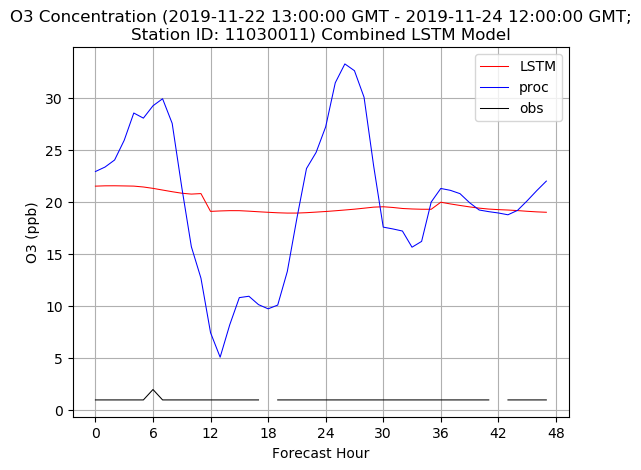

Forecast RMSE: 20.536721639355683
LSTM RMSE: 18.799436628692263
Forecast RMSE (first 24 hours): 23.608099362402896
LSTM RMSE (first 24 hours): 20.190946707423908
Forecast Pearson Correlation: 0.19246502779432922
LSTM Pearson Correlation: 0.24999581523735379

Maximum for first 15 hours:
Forecast Max: 29.94109344482422
LSTM Max: 21.57814335224111
AirNow Max: 2.0

Maximum for next 24 hours:
Forecast Max: 33.287689208984375
LSTM Max: 19.997919080034094
AirNow Max: 1.0


In [25]:
out = {}
out['model'] = []
out['forecast'] = []
out['airnow'] = []

rmse = {}
rmse['model'] = []
rmse['forecast'] = []

rmse1 = {}
rmse1['model'] = []
rmse1['forecast'] = []

pearson = {}
pearson['model'] = []
pearson['forecast'] = []

max1 = {}
max1['model'] = []
max1['forecast'] = []
max1['airnow'] = []

max2 = {}
max2['model'] = []
max2['forecast'] = []
max2['airnow'] = []

for loc in TEST_LOCATIONS:
    for day in TEST_DAYS:
        model_line_pre = model_output['pre'][day][loc][:12]
        model_line_mid = model_output['mid'][day][loc]
        model_line_end = model_output['end'][day][loc][-12:]

        model_line = np.concatenate([model_line_pre,model_line_mid,model_line_end])

        forecast_line = np.array(forecast_data.loc[day, loc][MODE])
        
        stamp = pd.Timestamp(day+' 13:00:00')

        airnow_line = np.array(airnow_data.loc[pd.date_range(stamp, periods=48, freq='h')][loc])
        airnow_line[airnow_line<=ERRVAL] = None

        plt.clf()
        plt.plot(model_line, label='LSTM', color="red", linewidth=0.75)
        plt.plot(forecast_line, label='proc', color="blue", linewidth=0.75)
        plt.plot(airnow_line, label='obs', color="black", linewidth=0.75)

        out['model'].append(model_line)
        out['forecast'].append(forecast_line)
        out['airnow'].append(airnow_line)

        plt.xlabel("Forecast Hour")
        plt.ylabel(MODE+" (ppb)")
        plt.xticks([0,6,12,18,24,30,36,42,48])
        plt.grid()

        plt.title(MODE+" Concentration ("+str(stamp)+" GMT - "+str(stamp+pd.Timedelta(47,'h'))+" GMT;\nStation ID: "+str(loc)+") Combined LSTM Model")
        plt.legend()

        if(not(os.path.exists(OUTPUT_DIR+str(loc)))):
            os.makedirs(OUTPUT_DIR+str(loc))
        plt.savefig(OUTPUT_DIR+str(loc)+"/base_"+day+".png", dpi=100)

        plt.show()

        model_cleaned = np.delete(model_line,np.argwhere(np.isnan(airnow_line)))
        forecast_cleaned = np.delete(forecast_line,np.argwhere(np.isnan(airnow_line)))
        airnow_cleaned = np.delete(airnow_line,np.argwhere(np.isnan(airnow_line)))

        output = []

        rmse['forecast'].append(mean_squared_error(forecast_cleaned, airnow_cleaned,squared=False))
        output.append("Forecast RMSE: "+str(rmse['forecast'][-1]))
        rmse['model'].append(mean_squared_error(model_cleaned, airnow_cleaned,squared=False))
        output.append("LSTM RMSE: "+str(rmse['model'][-1]))

        rmse1['forecast'].append(mean_squared_error(forecast_cleaned[:12], airnow_cleaned[:12],squared=False))
        output.append("Forecast RMSE (first 24 hours): "+str(rmse1['forecast'][-1]))
        rmse1['model'].append(mean_squared_error(model_cleaned[:12], airnow_cleaned[:12],squared=False))
        output.append("LSTM RMSE (first 24 hours): "+str(rmse1['model'][-1]))

        pearson['forecast'].append(stats.pearsonr(forecast_cleaned, airnow_cleaned)[0])
        output.append("Forecast Pearson Correlation: "+str(pearson['forecast'][-1]))
        pearson['model'].append(stats.pearsonr(model_cleaned, airnow_cleaned)[0])
        output.append("LSTM Pearson Correlation: "+str(pearson['model'][-1]))

        output.append("\nMaximum for first 15 hours:")
        max1['forecast'].append(max(forecast_cleaned[:16]))
        output.append("Forecast Max: "+str(max1['forecast'][-1]))
        max1['model'].append(max(model_cleaned[:16]))
        output.append("LSTM Max: "+str(max1['model'][-1]))
        max1['airnow'].append(max(airnow_cleaned[:16]))
        output.append("AirNow Max: "+str(max1['airnow'][-1]))

        output.append("\nMaximum for next 24 hours:")
        max2['forecast'].append(max(forecast_cleaned[16:40]))
        output.append("Forecast Max: "+str(max2['forecast'][-1]))
        max2['model'].append(max(model_cleaned[16:40]))
        output.append("LSTM Max: "+str(max2['model'][-1]))
        max2['airnow'].append(max(airnow_cleaned[16:40]))
        output.append("AirNow Max: "+str(max2['airnow'][-1]))

        with open(OUTPUT_DIR+"/"+str(loc)+"/out_"+day+".txt", "w") as f:
            for string in output:
                print(string)
                f.write(string)
                f.write('\n')

In [26]:
f = open(OUTFILE, "a")
f.write("Finished correction for "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.write("Finished cluster "+str(int(CURRENT_CLUSTER))+" at "+str(datetime.now())+"\n")
f.close()
            

In [27]:
weights = {}
for k in model.keys():
    model[k].save(OUTPUT_DIR+"model/tf/"+k)
    model[k].save(OUTPUT_DIR+'model/h5/'+k, save_format='h5')
    model[k].save_weights(OUTPUT_DIR+"model/save_weights/"+k+'/'+k)
    weights[k] = model[k].get_weights()
pickle.dump((TEST_LOCATIONS, TEST_DAYS, PHYSICAL_VARIABLES, out, rmse, rmse1, pearson, max1, max2, model_output, weights), open(OUTPUT_DIR+"/data.p", "wb"))

INFO:tensorflow:Assets written to: plots/single2/model/tf/pre/assets


INFO:tensorflow:Assets written to: plots/single2/model/tf/pre/assets


INFO:tensorflow:Assets written to: plots/single2/model/tf/mid/assets


INFO:tensorflow:Assets written to: plots/single2/model/tf/mid/assets


INFO:tensorflow:Assets written to: plots/single2/model/tf/end/assets


INFO:tensorflow:Assets written to: plots/single2/model/tf/end/assets
